In [ ]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano

from scipy import stats
from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
import arviz as az

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



### Overview

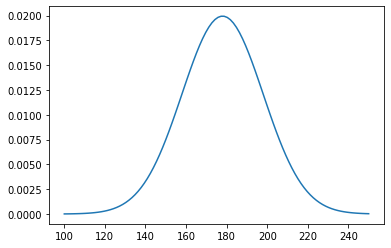

In [ ]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20))

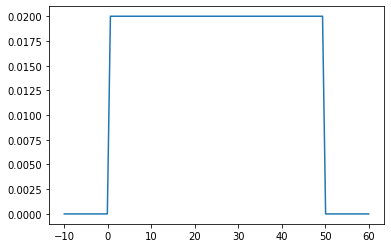

In [ ]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50))

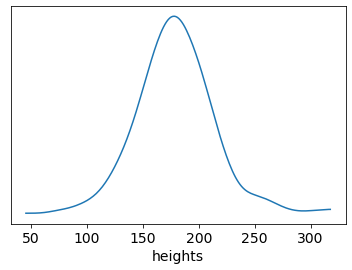

In [ ]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
pm.kdeplot(prior_h)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);

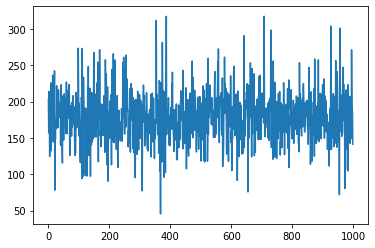

In [ ]:
plt.plot(prior_h)

### Exercise 1

In [ ]:
aux = pd.DataFrame(np.array([45, 40, 65, 31, 53])).reset_index().rename(columns={'index':'Individual',0:'weight'})
aux['expected height']=np.nan
aux['89% interval'] = np.nan
aux

,Individual,weight,expected height,89% interval
0,0,45,NaN,NaN
1,1,40,NaN,NaN
2,2,65,NaN,NaN
3,3,31,NaN,NaN
4,4,53,NaN,NaN


In [ ]:
d = pd.read_csv("data/Howell1.csv", sep=';', header=0)
d.shape

(544, 4)

In [ ]:
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [ ]:
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [ ]:
d2 = d[d.age >= 18].reset_index(drop=True)
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))
d2.shape

(352, 5)

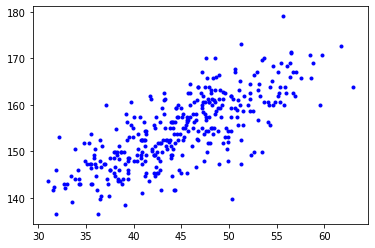

In [ ]:
plt.plot(d2.weight, d2.height, 'b.')

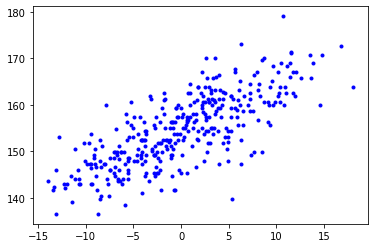

In [ ]:
plt.plot(d2.weight_c, d2.height, 'b.')

In [ ]:
d2.describe()

,height,weight,age,male,weight_c
count,352.000000,352.000000,352.000000,352.000000,3.520000e+02
mean,154.597093,44.990486,41.138494,0.468750,8.276208e-16
std,7.742332,6.456708,15.967855,0.499733,6.456708e+00
min,136.525000,31.071052,18.000000,0.000000,-1.391943e+01
25%,148.590000,40.256290,28.000000,0.000000,-4.734196e+00
50%,154.305000,44.792210,39.000000,0.000000,-1.982755e-01
75%,160.655000,49.292693,51.000000,1.000000,4.302208e+00
max,179.070000,62.992589,88.000000,1.000000,1.800210e+01


In [ ]:
with pm.Model() as model_linear:
    # Set data
    weight = pm.Data('weight', d2['weight_c'].values)
    height = pm.Data('height', d2['height'].values)

    # Set params
    α = pm.Normal('α', mu=178, sd=20)
    β = pm.Normal('β', mu=0, sd=10)
    σ = pm.Uniform('σ', lower=0, upper=50)
    μ = pm.Deterministic('μ', α + β * weight)
    
    height_hat = pm.Normal('height_hat', mu=μ, sd=σ, observed=height)
    # Sampling prior and posterior
    prior_linear = pm.sample_prior_predictive()
    trace_linear = pm.sample(draws=1000, tune=1000)
    posterior_pred = pm.sample_posterior_predictive(trace_linear)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


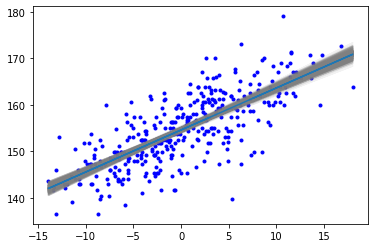

In [ ]:
x, y = d2.weight_c, d2.height
plt.plot(x, y, 'b.')

idx = range(0, len(trace_linear['α']), 10)
plt.plot(x, trace_linear['α'][idx] + trace_linear['β'][idx] * x[:, np.newaxis],
         c='gray', alpha=0.1)

plt.plot(x, trace_linear['α'].mean() + trace_linear['β'].mean() * x[:, np.newaxis])
plt.show()

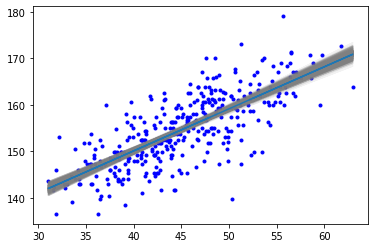

In [ ]:
x, xc, y = d2.weight, d2.weight_c, d2.height
plt.plot(x, y, 'b.')

idx = range(0, len(trace_linear['α']), 10)
y_pred = trace_linear['α'][idx] + trace_linear['β'][idx] * (xc[:, np.newaxis])
plt.plot(x, y_pred, c='gray', alpha=0.1)
y_pred = trace_linear['α'].mean() + trace_linear['β'].mean() * (xc[:, np.newaxis])
plt.plot(x, y_pred)
plt.show()

In [ ]:
az.summary(trace_linear, var_names=['α', 'β', 'σ'], credible_interval=0.89).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,154.60,0.29,154.10,155.16,0.0,0.0,5830.0,5830.0,5836.0,3165.0,1.0
β,0.90,0.04,0.82,0.98,0.0,0.0,4960.0,4953.0,4937.0,2725.0,1.0
σ,5.11,0.20,4.75,5.46,0.0,0.0,5715.0,5672.0,5707.0,3018.0,1.0


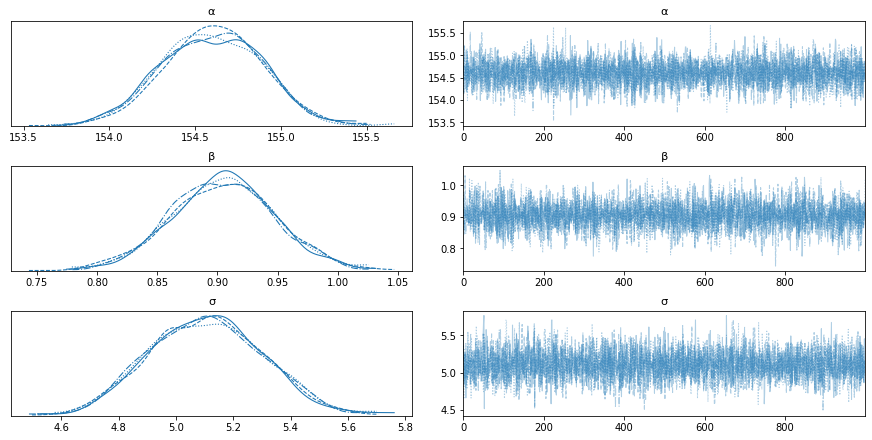

In [ ]:
pm.traceplot(trace_linear, var_names=['α', 'β', 'σ'])
plt.show()

In [ ]:
posterior_pred['height_hat'].shape

(4000, 352)

In [ ]:
d2['height_hat'] = np.mean(posterior_pred['height_hat'], axis=0)

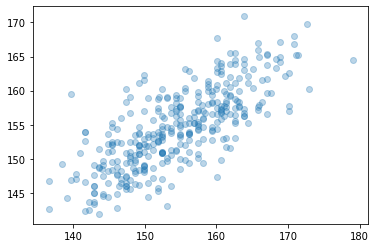

In [ ]:
plt.plot(d2['height'],d2['height_hat'], linestyle="None", 
         marker='o', alpha=0.3)

In [ ]:
print(f'The RMSE in X_train is {round(math.sqrt(mean_squared_error(d2.height.values, d2.height_hat.values)),2)} cm.')

The RMSE in X_train is 5.07 cm.


In [ ]:
hpdi = pm.hpd(posterior_pred['height_hat'], hdi_prob=.89)

In [ ]:
hpdi = pd.DataFrame(hpdi).rename({0:'lower_hpdi',1:'upper_hpdi'}, axis=1)
d3 = pd.concat([d2,hpdi], axis = 1)
round(d3.head(5),2)

,height,weight,age,male,weight_c,height_hat,lower_hpdi,upper_hpdi
0,151.76,47.83,63.0,1,2.84,157.06,147.92,167.18
1,139.70,36.49,63.0,0,-8.50,146.91,137.15,156.26
2,136.52,31.86,65.0,0,-13.13,142.65,132.77,151.97
3,156.84,53.04,41.0,1,8.05,161.87,152.08,171.42
4,145.42,41.28,51.0,0,-3.71,151.20,141.21,160.28


In [ ]:
with model_linear:
    pm.set_data({'weight':aux.weight.values-np.mean(d2.weight)})
    y_test = pm.sample_posterior_predictive(trace_linear)

In [ ]:
aux

,Individual,weight,expected height,89% interval
0,0,45,143.971666,"[106.88881868353481, 176.93532243231527]"
1,1,40,141.811420,"[108.90130807941657, 177.92679025341016]"
2,2,65,149.868541,"[114.7075653580429, 183.61098622549585]"
3,3,31,137.700309,"[101.24593150577311, 172.41185339412266]"
4,4,53,146.851920,"[115.30955918537285, 183.55645303651903]"


In [ ]:
y_test['height_hat'].shape
aux['expected height'] = y_test['height_hat'].mean(axis=0)
aux['89% interval'] = pd.Series(list(pm.hpd(y_test['height_hat'], hdi_prob=.89)))
aux

,Individual,weight,expected height,89% interval
0,0,45,154.683577,"[144.9701870050606, 163.80978686947955]"
1,1,40,150.108373,"[141.0978988543688, 160.48285856400662]"
2,2,65,172.616503,"[162.54121191381964, 181.9387836483904]"
3,3,31,141.921080,"[132.24194280933864, 151.7948318766127]"
4,4,53,161.779248,"[151.7366546461643, 170.92557274342013]"


### Excercise 2

In [ ]:
d2 = d
d2 = d2.assign(log_weight_c=pd.Series(np.log(d2.weight) - np.log(d2.weight).mean()))
d2.head()

,height,weight,age,male,log_weight_c
0,151.765,47.825606,63.0,1,0.425231
1,139.700,36.485807,63.0,0,0.154593
2,136.525,31.864838,65.0,0,0.019173
3,156.845,53.041915,41.0,1,0.528753
4,145.415,41.276872,51.0,0,0.277972


In [ ]:
with pm.Model() as model_log:
    # Set data
    weight = pm.Data('weight', d2['log_weight_c'].values)
    height = pm.Data('height', d2['height'].values)

    # Set params
    α = pm.Normal('α', mu=178, sd=20)
    β = pm.Normal('β', mu=0, sd=1)
    σ = pm.Uniform('σ', lower=0, upper=50)
    μ = pm.Deterministic('μ', α + β * weight)
    
    height_hat = pm.Normal('height_hat', mu=μ, sd=σ, observed=height)
    # Sampling prior and posterior
    prior_log = pm.sample_prior_predictive()
    trace_log = pm.sample(draws=1000, tune=1000)
    posterior_log = pm.sample_posterior_predictive(trace_log)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(trace_log, var_names=['α', 'β', 'σ'], credible_interval=0.89).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,138.29,0.84,136.71,139.88,0.02,0.01,1930.0,1930.0,1932.0,1906.0,1.0
β,16.24,1.41,13.64,18.83,0.03,0.02,1690.0,1646.0,1709.0,1590.0,1.0
σ,18.53,0.96,16.78,20.35,0.02,0.02,1687.0,1687.0,1699.0,1473.0,1.0


In [ ]:
aux

,Individual,weight,expected height,89% interval
0,0,45,144.410528,"[110.51619710429549, 178.7201819628171]"
1,1,40,142.596451,"[110.28031697138206, 180.53987256252222]"
2,2,65,150.058386,"[116.9371365841193, 187.01666953540393]"
3,3,31,137.952435,"[102.4123204933451, 172.34242400578387]"
4,4,53,146.805386,"[109.53299472237386, 179.371019264644]"


In [ ]:
with model_log:
    pm.set_data({'weight':np.log(aux.weight) - np.log(d2.weight).mean()})
    y_test = pm.sample_posterior_predictive(trace_log)  

In [ ]:
aux['expected height'] = y_test['height_hat'].mean(axis=0)
aux['89% interval'] = pd.Series(list(pm.hpd(y_test['height_hat'], hdi_prob=.89)))
aux

,Individual,weight,expected height,89% interval
0,0,45,144.272465,"[110.85780739930678, 179.79951837654522]"
1,1,40,142.369663,"[107.53500377611897, 178.77714028129694]"
2,2,65,150.350794,"[114.00355041613199, 186.1900423206993]"
3,3,31,137.336991,"[105.19031442428837, 173.76179492497513]"
4,4,53,146.600301,"[111.8201787321313, 182.5594731408394]"


In [ ]:
d2['adult'] = d2['age'] >= 18

In [ ]:
d2.head()

,height,weight,age,male,log_weight_c,adult
0,151.765,47.825606,63.0,1,0.425231,True
1,139.700,36.485807,63.0,0,0.154593,True
2,136.525,31.864838,65.0,0,0.019173,True
3,156.845,53.041915,41.0,1,0.528753,True
4,145.415,41.276872,51.0,0,0.277972,True


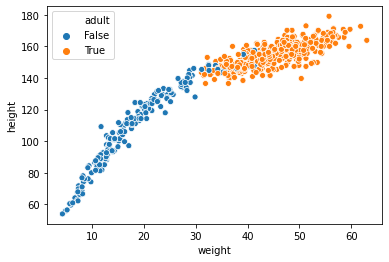

In [ ]:
sns.scatterplot(x='weight', y='height', data=d2, hue='adult')

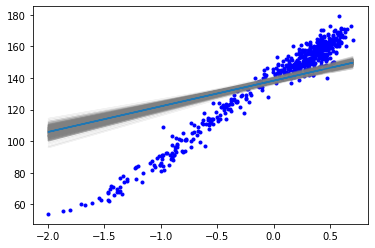

In [ ]:
x, y = d2.log_weight_c, d2.height
plt.plot(x, y, 'b.')

idx = range(0, len(trace_log['α']), 10)
y_pred = trace_log['α'][idx] + trace_log['β'][idx] * x[:, np.newaxis]
plt.plot(x, y_pred, c='gray', alpha=0.1)

y_pred = trace_log['α'].mean() + trace_log['β'].mean() * x[:, np.newaxis]
plt.plot(x, y_pred)
plt.show()

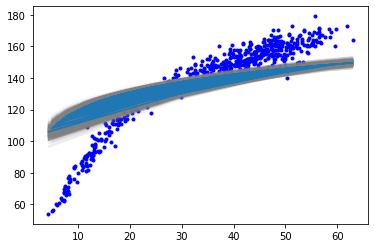

In [ ]:
x, x_c, y = d2.weight, d2.log_weight_c, d2.height
plt.plot(x, y, 'b.')

idx = range(0, len(trace_log['α']), 10)
y_pred = trace_log['α'][idx] + trace_log['β'][idx] * x_c[:, np.newaxis]
plt.plot(x, y_pred, c='gray', alpha=0.1)

y_pred = trace_log['α'].mean() + trace_log['β'].mean() * x_c[:, np.newaxis]
plt.plot(x, y_pred)
plt.show()

In [ ]:
d2 = d2.assign(height_hat=np.mean(posterior_log['height_hat'],axis=0))

height_pred_hpd = pm.hpd(posterior_log['height_hat'], hdi_prob=0.89)
hpdi = pd.DataFrame(height_pred_hpd).rename({0:'lower_hpdi',1:'upper_hpdi'}, axis=1)
d2 = pd.concat([d2,hpdi], axis = 1)
d2_plot = d2.melt(id_vars=['weight'],
                  value_vars=['height','height_hat'],
                  var_name='height_origin',
                  value_name='heights')
d2.head()

,height,weight,age,male,log_weight_c,adult,height_hat,lower_hpdi,upper_hpdi
0,151.765,47.825606,63.0,1,0.425231,True,145.069297,108.384552,178.327947
1,139.700,36.485807,63.0,0,0.154593,True,140.409667,104.515287,175.780188
2,136.525,31.864838,65.0,0,0.019173,True,138.633565,103.398652,173.221390
3,156.845,53.041915,41.0,1,0.528753,True,146.468991,110.938480,180.968567
4,145.415,41.276872,51.0,0,0.277972,True,142.896642,107.802005,177.692035


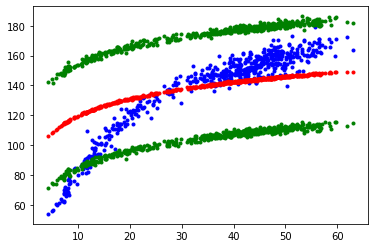

In [ ]:
plt.plot(d2.weight, d2.height, 'b.')
plt.plot(d2.weight, d2.height_hat, 'r.')
plt.plot(d2.weight, d2.lower_hpdi, 'g.')
plt.plot(d2.weight, d2.upper_hpdi, 'g.')
plt.show()

### Excercise 3

In [ ]:
d2 = d
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean())/d2.weight.std())
d2 = d2.assign(weight_c_2=pd.Series(d2.weight_c**2))
d2.head()

,height,weight,age,male,weight_c,weight_c_2
0,151.765,47.825606,63.0,1,0.829869,0.688682
1,139.700,36.485807,63.0,0,0.059459,0.003535
2,136.525,31.864838,65.0,0,-0.254483,0.064762
3,156.845,53.041915,41.0,1,1.184257,1.402466
4,145.415,41.276872,51.0,0,0.384957,0.148192


In [ ]:
with pm.Model() as model_poly:
    # Set data
    weight_c = pm.Data('weight_c', d2['weight_c'].values)
    weight_c2 = pm.Data('weight_c2', d2['weight_c_2'].values)
    height = pm.Data('height', d2['height'].values)

    # Set params
    α = pm.Normal('α', mu=178, sd=20)
    β = pm.Normal('β', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    σ = pm.Uniform('σ', lower=0, upper=50)
    μ = pm.Deterministic('μ', α + β * weight_c + β2 * weight_c2)
    
    height_hat = pm.Normal('height_hat', mu=μ, sd=σ, observed=height)
    # Sampling prior and posterior
    prior_poly = pm.sample_prior_predictive()
    trace_poly = pm.sample(draws=1000, tune=1000)
    posterior_poly = pm.sample_posterior_predictive(trace_poly)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β2, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
d2 = d2.assign(height_hat=np.mean(posterior_poly['height_hat'],axis=0))

height_pred_hpd = pm.hpd(posterior_poly['height_hat'], hdi_prob=0.89)
hpdi = pd.DataFrame(height_pred_hpd).rename({0:'lower_hpdi',1:'upper_hpdi'}, axis=1)
d2 = pd.concat([d2,hpdi], axis = 1)
d2_plot = d2.melt(id_vars=['weight'],
                  value_vars=['height','height_hat'],
                  var_name='height_origin',
                  value_name='heights')
d2.head()

,height,weight,age,male,weight_c,weight_c_2,height_hat,lower_hpdi,upper_hpdi
0,151.765,47.825606,63.0,1,0.829869,0.688682,157.501629,145.593899,168.195865
1,139.700,36.485807,63.0,0,0.059459,0.003535,147.955003,136.814816,159.296267
2,136.525,31.864838,65.0,0,-0.254483,0.064762,141.284683,130.570389,152.055722
3,156.845,53.041915,41.0,1,1.184257,1.402466,158.505245,146.565661,169.926400
4,145.415,41.276872,51.0,0,0.384957,0.148192,153.261292,141.952661,164.481586


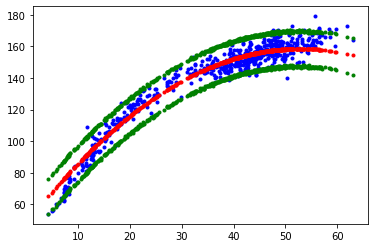

In [ ]:
plt.plot(d2.weight, d2.height, 'b.')
plt.plot(d2.weight, d2.height_hat, 'r.')
plt.plot(d2.weight, d2.lower_hpdi, 'g.')
plt.plot(d2.weight, d2.upper_hpdi, 'g.')
plt.show()